# Set up search for binaries in Hipparchos

In [49]:
import os
import sys
sys.path.append('../src')
import P_binary
import P_random
import P_posterior
import const as c
import time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import units as u
import pickle

%matplotlib inline

### Read in catalog

In [50]:
# Read in sample from Tycho-2 table
filename = ('../data/hipparchos/hip2.dat')
readme = ('../data/hipparchos/ReadMe')
hip_orig = Table.read(filename, format='cds', guess=False, readme=readme)

print hip_orig.colnames

['HIP', 'Sn', 'So', 'Nc', 'RArad', 'DErad', 'Plx', 'pmRA', 'pmDE', 'e_RArad', 'e_DErad', 'e_Plx', 'e_pmRA', 'e_pmDE', 'Ntr', 'F2', 'F1', 'var', 'ic', 'Hpmag', 'e_Hpmag', 'sHp', 'VA', 'B-V', 'e_B-V', 'V-I']


In [66]:
dtype = [('ID','i8'), ('ra','f8'), ('dec','f8'), ('mu_ra','f8'), ('mu_dec','f8'), \
         ('mu_ra_err','f8'), ('mu_dec_err','f8'), ('plx','f8'), ('plx_err','f8')]
hip = np.zeros(len(hip_orig), dtype=dtype)

hip['ID'] = hip_orig['HIP']
hip['ra'] = hip_orig['RArad'] * c.rad_to_deg
hip['dec'] = hip_orig['DErad'] * c.rad_to_deg
hip['mu_ra'] = hip_orig['pmRA']
hip['mu_dec'] = hip_orig['pmDE']
hip['mu_ra_err'] = hip_orig['e_pmRA']
hip['mu_dec_err'] = hip_orig['e_pmDE']
hip['plx'] = hip_orig['Plx']
hip['plx_err'] = hip_orig['e_Plx']

hip = hip[hip['plx']>0.0]


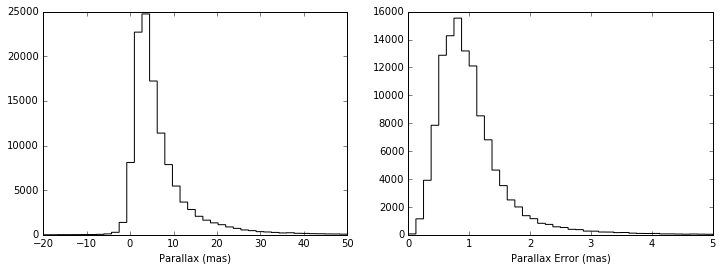

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].hist(hip['plx'], histtype='step', color='k', bins=40, range=(-20, 50))
ax[1].hist(hip['plx_err'], histtype='step', color='k', bins=40, range=(0, 5))

ax[0].set_xlabel('Parallax (mas)')
ax[1].set_xlabel('Parallax Error (mas)')

plt.show()

### Let's try to nail down a distance prior for Hipparcos

In [53]:
from scipy.integrate import quad
from scipy.optimize import minimize

upper = 10000.0

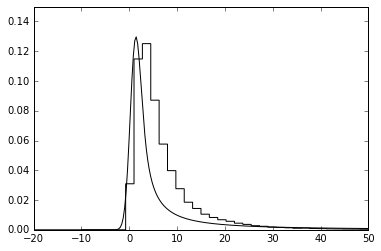

In [77]:
def get_integrand(x, y, gamma, sigma):
    return np.power(x, -(gamma+1.0)) * np.exp(-0.5*((y-x)/sigma)**2)


sigma = 1.5
#gamma, L, U = 1.5,  3.0, 100.0 # 0.12
gamma, L, U = 0.5,  0.698, 100.0 # 0.12

x = np.linspace(-10.0, 50.0, 200)
integral = np.zeros(len(x))
coeff = 1.0/np.sqrt(2.0*np.pi)/sigma * gamma / (L**(-gamma) - U**(-gamma))
for i in np.arange(len(x)):
    args = x[i], gamma, 1.0
    sol = quad(get_integrand, L, U, args=args)
    integral[i] = sol[0]
    
    # print i, x[i], integral[i]
    
plt.plot(x, coeff*integral, color='k')



plt.hist(hip['plx'], histtype='step', color='k', bins=40, range=(-20, 50), normed=True)

plt.ylim(0.0, 0.15)
plt.show()

In [83]:
def ln_posterior_minimize(x, data, sigma):
    N = len(data)
    
    gamma, L = x

    if L<0.0 or L > 5.0:
        return np.inf
    if gamma<0.01 or gamma>10.0:
        return np.inf

    ll = ln_likelihood(x, data, sigma)

    return -ll



def ln_likelihood(x, data, sigma):

    gamma, L = x

    N = len(data)


    integral = np.zeros(N)

    ran_indices = np.arange(N)
#    ran_indices = np.random.randint(len(data), size=N)


    for j in np.arange(N):
        i = ran_indices[j]
        args = data[i], gamma, sigma[i]
        
        # If integration range is negative
        if max(L, data[i]-3.0*sigma[i]) > min(upper, data[i]+3.0*sigma[i]): 
            print "Inf:", i, data[i], sigma[i], L, data[i]-3.0*sigma[i], upper, data[i]+3.0*sigma[i]
            return -np.inf

        sol = quad(get_integrand, max(L, data[i]-3.0*sigma[i]), min(upper, data[i]+3.0*sigma[i]), \
                   args=args, epsrel=1.0e-1, epsabs=1.0e-1)
        integral[j] = sol[0]
        
        # For very small (or negative) integrals, set to a small, near-zero value
        if integral[j] <=0.0 or np.isnan(integral[j]): integral[j]=1.0e-100

        
            
    ln_likelihood = - N/2.0 * np.log(2.0*np.pi) \
                        + N * np.log(gamma) \
                        - N * np.log(np.power(L, -gamma) - np.power(upper, -gamma)) \
                        + np.sum(np.log(integral))

    print gamma, L, ln_likelihood
                    
    return ln_likelihood





def ln_posterior_minimize_2(x, data, sigma):
    N = len(data)
    
    alpha, beta = x

    if alpha < 0.0 and beta < 0.0: return np.inf

    ll = ln_likelihood_2(x, data, sigma)

    return -ll




def get_integrand_2(x, y, alpha, beta, sigma):
    return x**alpha * np.exp(-beta*x - 0.5*((y-x)/sigma)**2)


def ln_likelihood_2(x, data, sigma):

    alpha, beta = x

    N = len(data)

    integral = np.zeros(N)

    ran_indices = np.arange(N)

    for j in np.arange(N):
        i = ran_indices[j]
        args = data[i], alpha, beta, sigma[i]
        
        sol = quad(get_integrand_2, data[i]-3.0*sigma[i], min(upper, data[i]+3.0*sigma[i]), \
                   args=args, epsrel=1.0e-1, epsabs=1.0e-1)
        integral[j] = sol[0]
        
        # For very small (or negative) integrals, set to a small, near-zero value
        if integral[j] <=0.0 or np.isnan(integral[j]): integral[j]=1.0e-100

        
            
    ln_likelihood = np.sum(np.log(integral))

    print alpha, beta, ln_likelihood
                    
    return ln_likelihood


In [84]:
def run_optimize(plx, sigma, ndim=3):

    # Initial Position
    p0 = np.array([2.0, 0.6])

    args = plx, sigma
#     res = minimize(ln_posterior_minimize, p0, args=args, method='Nelder-Mead')
    res = minimize(ln_posterior_minimize_2, p0, args=args, method='Nelder-Mead')
    
    return res

In [85]:
x = 2.0,  0.6
print ln_likelihood_2(x, hip['plx'], hip['plx_err'])

2.0 0.6 -43866.4441587
-43866.4441587


In [86]:
run_optimize(hip['plx'], hip['plx_err'])

2.0 0.6 -43866.4441587
2.1 0.6 -7292657.49872
2.0 0.63 -67851.9285709
1.9 0.63 -7346766.73862
2.05 0.6075 -7306212.60187
2.0 0.615 -55875.4471957
2.05 0.6 -7300526.55218
1.95 0.615 -7327598.19612
2.025 0.60375 -7307301.414
2.0 0.6075 -49875.0261334
2.025 0.6 -7304458.89146
1.975 0.6075 -7317998.96226
2.0125 0.601875 -7307845.64719
2.0 0.60375 -46871.757174
2.0125 0.6 -7306424.51172
1.9875 0.60375 -7313195.60844
2.00625 0.6009375 -7308117.72045
2.0 0.601875 -45369.3564131
2.00625 0.6 -7307407.1842
1.99375 0.601875 -7310792.99778
2.003125 0.60046875 -7308253.74624
2.0 0.6009375 -44617.9642526
2.003125 0.6 -7307898.48598
1.996875 0.6009375 -7309591.45906
2.0015625 0.600234375 -7308321.75641
2.0 0.60046875 -44242.220201
2.0015625 0.6 -7308144.12826
1.9984375 0.60046875 -7308990.63137
2.00078125 0.6001171875 -7308355.76083
2.0 0.600234375 -44054.3361792
2.00078125 0.6 -7308266.94724


/Library/Python/2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [14]:
hip_match = pickle.load(open('../data/hipparchos/hipparchos.p', 'rb'))
print hip_match.dtype

[('i_1', '<i4'), ('i_2', '<i4'), ('ID_1', '<i4'), ('ID_2', '<i4'), ('P_random', '<f8'), ('P_binary', '<f8'), ('P_posterior', '<f8'), ('theta', '<f8'), ('mu_ra_1', '<f8'), ('mu_dec_1', '<f8'), ('mu_ra_2', '<f8'), ('mu_dec_2', '<f8'), ('plx_1', '<f8'), ('plx_2', '<f8')]


In [30]:
for i in np.arange(len(hip_match)):
    
    dist1 = 1.0e3/hip_match['plx_1'][i]
    dist2 = 1.0e3/hip_match['plx_2'][i]
    if dist1 > 50.0 and dist1 < 100.0:
        print hip_match['ID_1'][i], hip_match['ID_2'][i], hip_match['mu_ra_1'][i], hip_match['mu_dec_1'][i], \
            hip_match['mu_ra_2'][i], hip_match['mu_dec_2'][i], dist1, dist2
        print "  ", hip_match['P_random'][i],hip_match['P_binary'][i], hip_match['P_posterior'][i]

185 190 -44.25 -114.37 -48.74 -117.9 77.399380805 87.489063867
   6.81838867893e-11 1.36978624434e-09 0.909459609073
1196 1197 99.42 -23.62 101.87 -25.08 77.7604976672 90.0090009001
   1.33098754214e-11 1.78683178729e-08 0.998512442379
1887 1891 38.88 1.97 41.46 -1.83 71.8907260963 84.6023688663
   8.59118320544e-10 4.65995969203e-09 0.730607753141
2292 2350 -112.15 -221.15 -105.63 -223.46 56.7214974475 49.9251123315
   2.41072594474e-10 4.96942508758e-11 0.0934384461824
2487 2578 93.97 -46.32 86.66 -50.33 51.652892562 45.5580865604
   1.32869062446e-09 1.75878683552e-10 0.0620764376525
2778 2779 -4.56 -2.75 -5.24 1.33 92.5925925926 109.289617486
   7.37639943965e-09 2.03423721057e-09 0.121179057439
3337 3340 -70.5 -157.83 -66.91 -165.1 54.4069640914 32.9055610398
   2.32412839786e-11 1.69817990454e-09 0.973357271856
4084 4088 4.87 -70.79 8.65 -86.59 63.2911392405 57.1102227299
   2.64093577895e-10 2.52708554307e-09 0.827122745545
5131 5132 44.49 -14.82 52.88 -11.88 84.3170320405 85.91

In [87]:
10**(18.50/5.)

5011.872336272725

In [27]:
#print hip_orig[hip_orig['HIP'] == 113368]
#print hip_orig[hip_orig['HIP'] == 113283]

print hip[hip['ID'] == 113368]
print hip[hip['ID'] == 113283]

[ (113368, 344.4117729897181, -29.621836802964395, 328.95, -164.67, 0.5, 0.35, 129.81, 0.47)]
[ (113283, 344.0992774136673, -31.56517888935032, 331.11, -158.98, 0.65, 0.48, 131.42, 0.62)]


In [48]:
Rsun_in_pc = c.pc_to_cm/c.Rsun_to_cm

print P_binary.get_P_binary(0.1*Rsun_in_pc, 1.0)

[  4.12149172e-09]
